In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

# 필요한 라이브러리들 import하기

# Load Dataset

In [9]:
data = pd.read_csv('dataset/005930.KS_5y.csv') # 데이터셋 폴더의 csv파일 불러와서 data에 저장
data.head() # data의 처음 5개 데이터만 보여주는 함수

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


# Compute Mid Price

In [3]:
high_prices = data['High'].values # high의 값들만 가져와서 저장
low_prices = data['Low'].values # low의 값들만 가져와서 저장
mid_prices = (high_prices + low_prices) / 2 # 각각의 중간값을 구해서 저장

# Create Windows

In [4]:
seq_len = 50 # 윈도우 크기 정해주기
sequence_length = seq_len + 1 # 윈도우 크기 + 1

result = [] # 데이터 자른 결과를 저장할 변수 선언
for index in range(len(mid_prices) - sequence_length): # 중간값 - 윈도우 사이즈 만큼 for문 반복
    result.append(mid_prices[index: index + sequence_length]) # 윈도우 크기만큼 데이터 잘라서 result에 저장

# Normalize Data

In [5]:
normalized_data = [] # 자른 데이터 정규화 시켜서 저장할 변수
for window in result: # result에 있는거 하나씩 가져와서 반복 시킴
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window] # 정규화
    normalized_data.append(normalized_window) # normalized_data에 저장

result = np.array(normalized_data) # 넘파이 어레이로 변환

# split train and test data
row = int(round(result.shape[0] * 0.9)) # 열 길이 정하기
train = result[:row, :] # 90퍼센트를 학습 데이터로 사용
np.random.shuffle(train) # 학습 데이터 순서 섞기

# 학습 데이터를 문제와 정답으로 나눔
x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

# 테스트 데이터를 문제와 정답으로 나눔
x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

# 학습 데이터의 문제와 테스트 데이터의 문제의 모양을 살펴봄
x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

# Build a Model

In [6]:
model = Sequential() # 케라스의 Sequentual 사용

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1))) # lstm층 추가

model.add(LSTM(64, return_sequences=False)) # lstm층 추가

model.add(Dense(1, activation='linear')) # lstm층 추가

model.compile(loss='mse', optimizer='rmsprop') # 손실함수는 mse, 최적화 알고리즘은 rmsporp으로 컴파일
 
model.summary() # 모델 요약해주는 함수

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [7]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

# 모델 실질적으로 훈련시킴, 검증용으로 테스트 데이터 사용, 배치 사이즈는 10, 반복 횟수는 20

Epoch 1/20
106/106 [==============================] - 6s 25ms/step - loss: 0.0013 - val_loss: 5.6871e-04
Epoch 2/20
106/106 [==============================] - 2s 18ms/step - loss: 6.9866e-04 - val_loss: 7.5898e-04
Epoch 3/20
106/106 [==============================] - 2s 18ms/step - loss: 5.4615e-04 - val_loss: 3.6920e-04
Epoch 4/20
106/106 [==============================] - 2s 18ms/step - loss: 4.3206e-04 - val_loss: 1.9461e-04
Epoch 5/20
106/106 [==============================] - 2s 17ms/step - loss: 3.3817e-04 - val_loss: 2.1140e-04
Epoch 6/20
106/106 [==============================] - 2s 18ms/step - loss: 2.8802e-04 - val_loss: 2.1004e-04
Epoch 7/20
106/106 [==============================] - 2s 18ms/step - loss: 2.4443e-04 - val_loss: 1.5594e-04
Epoch 8/20
106/106 [==============================] - 2s 18ms/step - loss: 2.3199e-04 - val_loss: 2.0178e-04
Epoch 9/20
106/106 [==============================] - 2s 17ms/step - loss: 2.3184e-04 - val_loss: 1.9738e-04
Epoch 10/20
106/106 [==

# Prediction

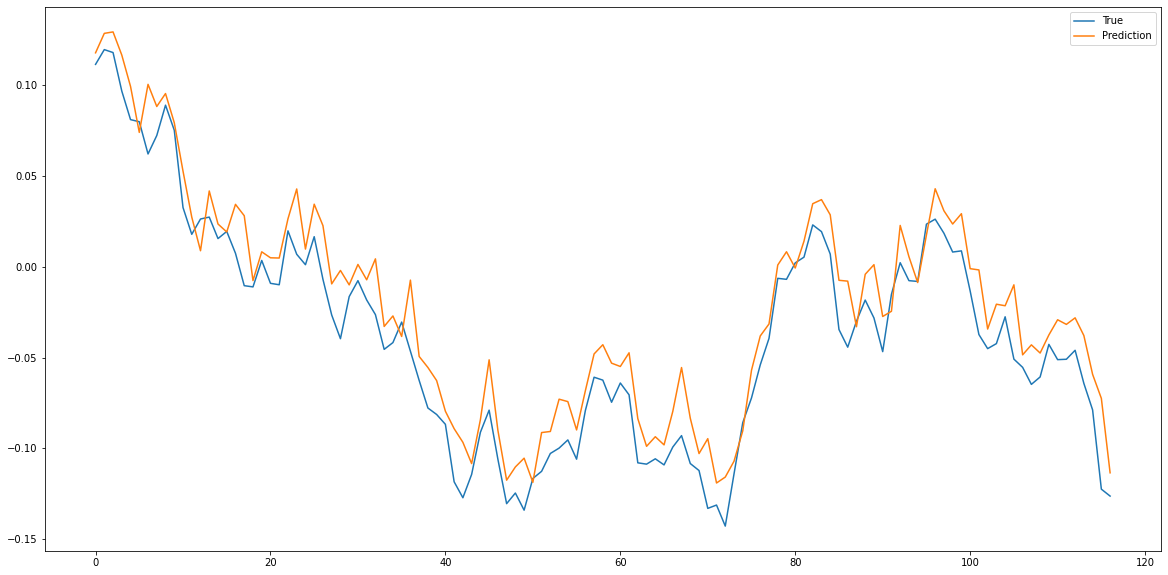

In [8]:
pred = model.predict(x_test) # 훈련시킨 모델로 예측 해보기

fig = plt.figure(facecolor='white', figsize=(20, 10)) # 그림판 크기 설정

# 그림 그리기
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()